<a href="https://colab.research.google.com/github/bessszilard/Udacity-Self-Driving-Car-Engineer-Nanodegree-Program/blob/master/Project-4-Behavioral-Cloning/Behavioral_cloning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bessszilard/Self-Driving-Car-Simulator-Data

fatal: destination path 'Self-Driving-Car-Simulator-Data' already exists and is not an empty directory.


In [2]:
!ls
!ls Self-Driving-Car-Simulator-Data

model.h5  sample_data  Self-Driving-Car-Simulator-Data
driving_log.csv  IMG  LICENSE  README.md


In [3]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense, Lambda
from keras.layers import Cropping2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from google.colab import files

Using TensorFlow backend.


In [0]:
# lines = []
# with open("../data/driving_log.csv") as csvfile:
#     reader = csv.reader(csvfile)
#     for line in reader:
#         lines.appedn

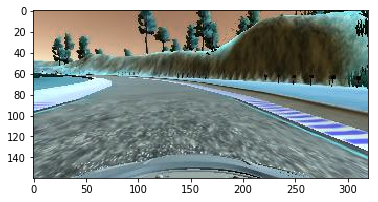

In [5]:
# datadir = 'Self-Driving-Car-Simulator-Data'
# colums = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colums)
# pd.set_option('display.max_colwidth', -1)
# data.head()

lines = []
with open('Self-Driving-Car-Simulator-Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

def path_to_image(dir, line):
    filename = source_path.split('\\')[-1] 
    current_path = dir + filename
    return cv2.imread(current_path)

for line in lines:
    steering_center = float(line[3])
    
    # create adjusted steering measurements for the side camera images
    correction = 0.2 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
            
    source_path = line[0]
    filename = source_path.split('\\')[-1]
    current_path = 'Self-Driving-Car-Simulator-Data/IMG/' + filename
    
    image = cv2.imread(current_path)
    
    dir = 'Self-Driving-Car-Simulator-Data/IMG/'
    image_center = path_to_image(dir, line[0])
    image_left   = path_to_image(dir, line[1])
    image_right  = path_to_image(dir, line[2])
    
#     images.append(image)
#     measurement = float(line[3])
#     measurements.append(measurement)
    images.extend((image_center, image_left, image_right))
    measurements.extend((steering_center, steering_left, steering_right))

augmented_images = images
augemented_measurements = measurements
# augmented_images, augemented_measurements = [], []    
# for image, measurement in zip(images, measurements):
#     augmented_images.append(image)
#     augemented_measurements.append(measurement)
#     augmented_images.append(cv2.flip(image, 1))
#     augemented_measurements.append(-measurement)
    
plt.imshow(images[100])
# plt.imshow(measurements[100])

In [6]:
len(augmented_images)
print(measurements[100])

-0.09999999999999998


In [7]:
X_train = np.array(augmented_images)
y_train = np.array(augemented_measurements)

model = Sequential()
model.add(Lambda(lambda x: ((x / 255.0) - 0.5), input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25),(0, 0))))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPool2D())
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (5, 5), activation="relu")`
  if __name__ == '__main__':


Train on 17198 samples, validate on 4300 samples
Epoch 1/7
17198/17198 [==============================] - 14s 801us/step - loss: 0.0952 - val_loss: 0.0318
Epoch 2/7
17198/17198 [==============================] - 10s 593us/step - loss: 0.0352 - val_loss: 0.0322
Epoch 3/7
17198/17198 [==============================] - 10s 597us/step - loss: 0.0345 - val_loss: 0.0316
Epoch 4/7
17198/17198 [==============================] - 10s 602us/step - loss: 0.0338 - val_loss: 0.0321
Epoch 5/7
17198/17198 [==============================] - 10s 607us/step - loss: 0.0336 - val_loss: 0.0324
Epoch 6/7
17198/17198 [==============================] - 10s 600us/step - loss: 0.0331 - val_loss: 0.0323
Epoch 7/7
17198/17198 [==============================] - 10s 601us/step - loss: 0.0330 - val_loss: 0.0323


In [0]:
model.save('model.h5')
# !ls
files.download('model.h5')